<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Latent-Personal-Analysis-in-Python" data-toc-modified-id="Latent-Personal-Analysis-in-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Latent Personal Analysis in Python</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Creating-the-domain" data-toc-modified-id="Creating-the-domain-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Creating the domain</a></span></li><li><span><a href="#Creating-an-instance-of-LPA" data-toc-modified-id="Creating-an-instance-of-LPA-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Creating an instance of <code>LPA</code></a></span></li><li><span><a href="#Creating-Signatures" data-toc-modified-id="Creating-Signatures-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Creating Signatures</a></span></li><li><span><a href="#Distances-between-pairs-of-categories-(Sockpuppet-Distance)" data-toc-modified-id="Distances-between-pairs-of-categories-(Sockpuppet-Distance)-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Distances between pairs of categories (Sockpuppet Distance)</a></span></li></ul></li><li><span><a href="#Further-analysis" data-toc-modified-id="Further-analysis-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Further analysis</a></span></li></ul></li><li><span><a href="#Good-Luck!" data-toc-modified-id="Good-Luck!-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Good Luck!</a></span><ul class="toc-item"><li><span><a href="#References" data-toc-modified-id="References-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>References</a></span></li></ul></li></ul></div>

## Latent Personal Analysis in Python
by Uri Alon and Alex Abbey

This short tutorial will demonstrate how to use the Python implementation of LPA, as described in the [article](https://link.springer.com/article/10.1007/s11257-021-09295-7) in User Modeling and User-Adapted Interaction.

LPA helps analyze a corpus of text, or any set of data, by taking into account the missing popular elements and frequently used yet generally infrequent elements. We will be using the terms element, category and domain. It can be helpful to think of the element as a word, a category as a chapter of a book, and the domain as the book.

The first implementation for LPA was written in SQL and can be found [here](https://github.com/hagitbenshoshan/text_distance/) - 
For very large datasets, users of this package are encouraged to switch to the SQL implementation using cloud infrustructure, as the calculation of the results will be much faster.

Dependencies:
- pandas
- numpy
- scipy 

In [2]:
import pandas as pd
from LPA import LPA
from matplotlib import pyplot as plt

C:\Users\212778050\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\212778050\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\212778050\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In this tutorial we demonstrate LPA using a small portion of the LOCO dataset (Miani, 2021), the unprocessed data available here: https://osf.io/snpcg/. The data you are using should consist of a count of elements per category. For instance, with this dataset, each category is an article, each element is a (tokenized) word, and the frequency is a count of the amount of times the word appeared in an article. The input should be a csv file with the columns: `element`, `category`, `frequency_in_category`. 

In [15]:
df = pd.read_csv('./frequency_nachi.csv')
df.describe(include="all")
print(df.shape)
df.head()
# df.shape

(8457601, 3)


,element,frequency_in_category,category
0,noth,29,0_1
1,hool,27,0_1
2,owl,27,0_1
3,eye,23,0_1
4,tree,22,0_1


#### Creating the domain
The domain (DVR) consists of the frequency of all elements from all categories together. 

In [17]:
dvr = LPA.create_dvr(df)
dvr.head()

,element,frequency_in_category,global_weight
0,said,184763,0.008823
1,look,183497,0.008763
2,back,143870,0.006870
3,go,135474,0.006469
4,like,134706,0.006433


#### Creating an instance of `LPA`
To create an instance of the `LPA` object you must create a `dvr`, either by creating it ahead of time and loading it from a file, or by using the static method `create_dvr`. Epsilon is set to 1 / (domain size * `epsilon_frac`), where if `epsilon_frac` is a number greater than 1 will decrease the weight of epsilon (the default weight given to missing terms) while a number between 0 and 1 will increase it. By default `epsilon_frac` is set to 2.

In [18]:
lpa = LPA(dvr, categories=500, epsilon_frac=2)

In [19]:
# df_1 = df[df['category'] == '0_1']
pairs = pd.read_csv('id_pairs_for_calc_distances.csv')
pairs.head()

,text_id_1,text_id_2,same
0,0_1,0_2,True
1,1_1,1_2,True
2,2_1,2_2,True
3,3_1,3_2,True
4,4_1,4_2,True


In [20]:
pairs.shape, df.shape
pairs.head()
# df.head()

,text_id_1,text_id_2,same
0,0_1,0_2,True
1,1_1,1_2,True
2,2_1,2_2,True
3,3_1,3_2,True
4,4_1,4_2,True


In [21]:
pairs['distance'] = None
for ix,row in pairs.iterrows():
    
    id1 = row['text_id_1']
    id2 = row['text_id_2']
    print(id1,id2)
    df_single_pair = df[df['category'].isin([id1,id2])].reset_index()

    df_single_pair['category'].unique()
    sigs = lpa.create_signatures(df_single_pair)
    dis_mtx = lpa.sockpuppet_distance(signatures1=sigs, signatures2=sigs)
    distance = dis_mtx.iloc[1][0]
    pairs.loc[ix,'distance' ]=distance
pairs.tail()

0_1 0_2
func: sockpuppet_distance took: 0:00:00.215798
1_1 1_2
func: sockpuppet_distance took: 0:00:00.225273
2_1 2_2
func: sockpuppet_distance took: 0:00:00.258306
3_1 3_2
func: sockpuppet_distance took: 0:00:00.253735
4_1 4_2
func: sockpuppet_distance took: 0:00:00.201163
5_1 5_2
func: sockpuppet_distance took: 0:00:00.240825
6_1 6_2
func: sockpuppet_distance took: 0:00:00.226842
7_1 7_2
func: sockpuppet_distance took: 0:00:00.254689
8_1 8_2
func: sockpuppet_distance took: 0:00:00.193849
9_1 9_2
func: sockpuppet_distance took: 0:00:00.170411
10_1 10_2
func: sockpuppet_distance took: 0:00:00.222691
11_1 11_2
func: sockpuppet_distance took: 0:00:00.213204
12_1 12_2
func: sockpuppet_distance took: 0:00:00.191967
13_1 13_2
func: sockpuppet_distance took: 0:00:00.196740
14_1 14_2
func: sockpuppet_distance took: 0:00:00.261727
15_1 15_2
func: sockpuppet_distance took: 0:00:00.407244
16_1 16_2
func: sockpuppet_distance took: 0:00:00.198530
17_1 17_2
func: sockpuppet_distance took: 0:00:00.3

func: sockpuppet_distance took: 0:00:00.229289
144_1 144_2
func: sockpuppet_distance took: 0:00:00.239527
145_1 145_2
func: sockpuppet_distance took: 0:00:00.272359
146_1 146_2
func: sockpuppet_distance took: 0:00:00.254689
147_1 147_2
func: sockpuppet_distance took: 0:00:00.250769
148_1 148_2
func: sockpuppet_distance took: 0:00:00.321363
149_1 149_2
func: sockpuppet_distance took: 0:00:00.305418
150_1 150_2
func: sockpuppet_distance took: 0:00:00.309118
151_1 151_2
func: sockpuppet_distance took: 0:00:00.253042
152_1 152_2
func: sockpuppet_distance took: 0:00:00.165919
153_1 153_2
func: sockpuppet_distance took: 0:00:00.239122
154_1 154_2
func: sockpuppet_distance took: 0:00:00.309757
155_1 155_2
func: sockpuppet_distance took: 0:00:00.342406
156_1 156_2
func: sockpuppet_distance took: 0:00:00.345784
157_1 157_2
func: sockpuppet_distance took: 0:00:00.199167
158_1 158_2
func: sockpuppet_distance took: 0:00:00.221151
159_1 159_2
func: sockpuppet_distance took: 0:00:00.239713
160_1 160

func: sockpuppet_distance took: 0:00:00.195267
284_1 284_2
func: sockpuppet_distance took: 0:00:00.138479
285_1 285_2
func: sockpuppet_distance took: 0:00:00.215228
286_1 286_2
func: sockpuppet_distance took: 0:00:00.220195
287_1 287_2
func: sockpuppet_distance took: 0:00:00.168369
288_1 288_2
func: sockpuppet_distance took: 0:00:00.159404
289_1 289_2
func: sockpuppet_distance took: 0:00:00.193276
290_1 290_2
func: sockpuppet_distance took: 0:00:00.173351
291_1 291_2
func: sockpuppet_distance took: 0:00:00.254997
292_1 292_2
func: sockpuppet_distance took: 0:00:00.223162
293_1 293_2
func: sockpuppet_distance took: 0:00:00.211211
294_1 294_2
func: sockpuppet_distance took: 0:00:00.168504
295_1 295_2
func: sockpuppet_distance took: 0:00:00.211184
296_1 296_2
func: sockpuppet_distance took: 0:00:00.206221
297_1 297_2
func: sockpuppet_distance took: 0:00:00.226169
298_1 298_2
func: sockpuppet_distance took: 0:00:00.215285
299_1 299_2
func: sockpuppet_distance took: 0:00:00.216182
300_1 300

func: sockpuppet_distance took: 0:00:00.218339
423_1 423_2
func: sockpuppet_distance took: 0:00:00.225995
424_1 424_2
func: sockpuppet_distance took: 0:00:00.198522
425_1 425_2
func: sockpuppet_distance took: 0:00:00.190558
426_1 426_2
func: sockpuppet_distance took: 0:00:00.166207
427_1 427_2
func: sockpuppet_distance took: 0:00:00.221995
428_1 428_2
func: sockpuppet_distance took: 0:00:00.201152
429_1 429_2
func: sockpuppet_distance took: 0:00:00.250034
430_1 430_2
func: sockpuppet_distance took: 0:00:00.168509
431_1 431_2
func: sockpuppet_distance took: 0:00:00.295265
432_1 432_2
func: sockpuppet_distance took: 0:00:00.219572
433_1 433_2
func: sockpuppet_distance took: 0:00:00.213454
434_1 434_2
func: sockpuppet_distance took: 0:00:00.272473
435_1 435_2
func: sockpuppet_distance took: 0:00:00.233278
436_1 436_2
func: sockpuppet_distance took: 0:00:00.240100
437_1 437_2
func: sockpuppet_distance took: 0:00:00.209195
438_1 438_2
func: sockpuppet_distance took: 0:00:00.232150
439_1 439

func: sockpuppet_distance took: 0:00:00.299496
562_1 562_2
func: sockpuppet_distance took: 0:00:00.247841
563_1 563_2
func: sockpuppet_distance took: 0:00:00.266002
564_1 564_2
func: sockpuppet_distance took: 0:00:00.288736
565_1 565_2
func: sockpuppet_distance took: 0:00:00.210767
566_1 566_2
func: sockpuppet_distance took: 0:00:00.289929
567_1 567_2
func: sockpuppet_distance took: 0:00:00.284098
568_1 568_2
func: sockpuppet_distance took: 0:00:00.200167
569_1 569_2
func: sockpuppet_distance took: 0:00:00.209523
570_1 570_2
func: sockpuppet_distance took: 0:00:00.219445
571_1 571_2
func: sockpuppet_distance took: 0:00:00.254355
572_1 572_2
func: sockpuppet_distance took: 0:00:00.204467
573_1 573_2
func: sockpuppet_distance took: 0:00:00.212038
574_1 574_2
func: sockpuppet_distance took: 0:00:00.393241
575_1 575_2
func: sockpuppet_distance took: 0:00:00.554517
576_1 576_2
func: sockpuppet_distance took: 0:00:00.298203
577_1 577_2
func: sockpuppet_distance took: 0:00:00.247359
578_1 578

func: sockpuppet_distance took: 0:00:00.295668
701_1 701_2
func: sockpuppet_distance took: 0:00:00.212848
702_1 702_2
func: sockpuppet_distance took: 0:00:00.132281
703_1 703_2
func: sockpuppet_distance took: 0:00:00.132693
704_1 704_2
func: sockpuppet_distance took: 0:00:00.141774
705_1 705_2
func: sockpuppet_distance took: 0:00:00.129452
706_1 706_2
func: sockpuppet_distance took: 0:00:00.133919
707_1 707_2
func: sockpuppet_distance took: 0:00:00.141977
708_1 708_2
func: sockpuppet_distance took: 0:00:00.121725
709_1 709_2
func: sockpuppet_distance took: 0:00:00.213754
710_1 710_2
func: sockpuppet_distance took: 0:00:00.183355
711_1 711_2
func: sockpuppet_distance took: 0:00:00.184079
712_1 712_2
func: sockpuppet_distance took: 0:00:00.200928
713_1 713_2
func: sockpuppet_distance took: 0:00:00.203177
714_1 714_2
func: sockpuppet_distance took: 0:00:00.184781
715_1 715_2
func: sockpuppet_distance took: 0:00:00.200190
716_1 716_2
func: sockpuppet_distance took: 0:00:00.217864
717_1 717

func: sockpuppet_distance took: 0:00:00.185518
840_1 840_2
func: sockpuppet_distance took: 0:00:00.221348
841_1 841_2
func: sockpuppet_distance took: 0:00:00.188497
842_1 842_2
func: sockpuppet_distance took: 0:00:00.227396
843_1 843_2
func: sockpuppet_distance took: 0:00:00.217420
844_1 844_2
func: sockpuppet_distance took: 0:00:00.165578
845_1 845_2
func: sockpuppet_distance took: 0:00:00.153606
846_1 846_2
func: sockpuppet_distance took: 0:00:00.197491
847_1 847_2
func: sockpuppet_distance took: 0:00:00.199467
848_1 848_2
func: sockpuppet_distance took: 0:00:00.201483
849_1 849_2
func: sockpuppet_distance took: 0:00:00.203458
850_1 850_2
func: sockpuppet_distance took: 0:00:00.313131
851_1 851_2
func: sockpuppet_distance took: 0:00:00.192538
852_1 852_2
func: sockpuppet_distance took: 0:00:00.164582
853_1 853_2
func: sockpuppet_distance took: 0:00:00.223365
854_1 854_2
func: sockpuppet_distance took: 0:00:00.194502
855_1 855_2
func: sockpuppet_distance took: 0:00:00.220443
856_1 856

func: sockpuppet_distance took: 0:00:00.193759
979_1 979_2
func: sockpuppet_distance took: 0:00:00.201922
980_1 980_2
func: sockpuppet_distance took: 0:00:00.186561
981_1 981_2
func: sockpuppet_distance took: 0:00:00.202614
982_1 982_2
func: sockpuppet_distance took: 0:00:00.210629
983_1 983_2
func: sockpuppet_distance took: 0:00:00.203808
984_1 984_2
func: sockpuppet_distance took: 0:00:00.231070
985_1 985_2
func: sockpuppet_distance took: 0:00:00.188339
986_1 986_2
func: sockpuppet_distance took: 0:00:00.208668
987_1 987_2
func: sockpuppet_distance took: 0:00:00.257108
988_1 988_2
func: sockpuppet_distance took: 0:00:00.204420
989_1 989_2
func: sockpuppet_distance took: 0:00:00.247339
990_1 990_2
func: sockpuppet_distance took: 0:00:00.253322
991_1 991_2
func: sockpuppet_distance took: 0:00:00.245347
992_1 992_2
func: sockpuppet_distance took: 0:00:00.261311
993_1 993_2
func: sockpuppet_distance took: 0:00:00.189493
994_1 994_2
func: sockpuppet_distance took: 0:00:00.169566
995_1 995

func: sockpuppet_distance took: 0:00:00.227451
1114_1 1114_2
func: sockpuppet_distance took: 0:00:00.219333
1115_1 1115_2
func: sockpuppet_distance took: 0:00:00.236299
1116_1 1116_2
func: sockpuppet_distance took: 0:00:00.163526
1117_1 1117_2
func: sockpuppet_distance took: 0:00:00.179835
1118_1 1118_2
func: sockpuppet_distance took: 0:00:00.196961
1119_1 1119_2
func: sockpuppet_distance took: 0:00:00.196387
1120_1 1120_2
func: sockpuppet_distance took: 0:00:00.136691
1121_1 1121_2
func: sockpuppet_distance took: 0:00:00.204175
1122_1 1122_2
func: sockpuppet_distance took: 0:00:00.174501
1123_1 1123_2
func: sockpuppet_distance took: 0:00:00.237363
1124_1 1124_2
func: sockpuppet_distance took: 0:00:00.228281
1125_1 1125_2
func: sockpuppet_distance took: 0:00:00.182514
1126_1 1126_2
func: sockpuppet_distance took: 0:00:00.203507
1127_1 1127_2
func: sockpuppet_distance took: 0:00:00.198014
1128_1 1128_2
func: sockpuppet_distance took: 0:00:00.203597
1129_1 1129_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.242599
1249_1 1249_2
func: sockpuppet_distance took: 0:00:00.289229
1250_1 1250_2
func: sockpuppet_distance took: 0:00:00.235372
1251_1 1251_2
func: sockpuppet_distance took: 0:00:00.221383
1252_1 1252_2
func: sockpuppet_distance took: 0:00:00.165575
1253_1 1253_2
func: sockpuppet_distance took: 0:00:00.264562
1254_1 1254_2
func: sockpuppet_distance took: 0:00:00.223024
1255_1 1255_2
func: sockpuppet_distance took: 0:00:00.211040
1256_1 1256_2
func: sockpuppet_distance took: 0:00:00.222281
1257_1 1257_2
func: sockpuppet_distance took: 0:00:00.253849
1258_1 1258_2
func: sockpuppet_distance took: 0:00:00.207447
1259_1 1259_2
func: sockpuppet_distance took: 0:00:00.281445
1260_1 1260_2
func: sockpuppet_distance took: 0:00:00.204199
1261_1 1261_2
func: sockpuppet_distance took: 0:00:00.214154
1262_1 1262_2
func: sockpuppet_distance took: 0:00:00.307166
1263_1 1263_2
func: sockpuppet_distance took: 0:00:00.211475
1264_1 1264_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.222941
1384_1 1384_2
func: sockpuppet_distance took: 0:00:00.214085
1385_1 1385_2
func: sockpuppet_distance took: 0:00:00.170402
1386_1 1386_2
func: sockpuppet_distance took: 0:00:00.183617
1387_1 1387_2
func: sockpuppet_distance took: 0:00:00.250205
1388_1 1388_2
func: sockpuppet_distance took: 0:00:00.254859
1389_1 1389_2
func: sockpuppet_distance took: 0:00:00.200208
1390_1 1390_2
func: sockpuppet_distance took: 0:00:00.236050
1391_1 1391_2
func: sockpuppet_distance took: 0:00:00.245060
1392_1 1392_2
func: sockpuppet_distance took: 0:00:00.226729
1393_1 1393_2
func: sockpuppet_distance took: 0:00:00.255176
1394_1 1394_2
func: sockpuppet_distance took: 0:00:00.247505
1395_1 1395_2
func: sockpuppet_distance took: 0:00:00.263622
1396_1 1396_2
func: sockpuppet_distance took: 0:00:00.229680
1397_1 1397_2
func: sockpuppet_distance took: 0:00:00.168501
1398_1 1398_2
func: sockpuppet_distance took: 0:00:00.174079
1399_1 1399_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.216801
1519_1 1519_2
func: sockpuppet_distance took: 0:00:00.210632
1520_1 1520_2
func: sockpuppet_distance took: 0:00:00.180106
1521_1 1521_2
func: sockpuppet_distance took: 0:00:00.225279
1522_1 1522_2
func: sockpuppet_distance took: 0:00:00.255491
1523_1 1523_2
func: sockpuppet_distance took: 0:00:00.196474
1524_1 1524_2
func: sockpuppet_distance took: 0:00:00.194502
1525_1 1525_2
func: sockpuppet_distance took: 0:00:00.204339
1526_1 1526_2
func: sockpuppet_distance took: 0:00:00.245013
1527_1 1527_2
func: sockpuppet_distance took: 0:00:00.262836
1528_1 1528_2
func: sockpuppet_distance took: 0:00:00.201904
1529_1 1529_2
func: sockpuppet_distance took: 0:00:00.251708
1530_1 1530_2
func: sockpuppet_distance took: 0:00:00.230416
1531_1 1531_2
func: sockpuppet_distance took: 0:00:00.223366
1532_1 1532_2
func: sockpuppet_distance took: 0:00:00.200466
1533_1 1533_2
func: sockpuppet_distance took: 0:00:00.232248
1534_1 1534_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.207318
1654_1 1654_2
func: sockpuppet_distance took: 0:00:00.187120
1655_1 1655_2
func: sockpuppet_distance took: 0:00:00.224391
1656_1 1656_2
func: sockpuppet_distance took: 0:00:00.219573
1657_1 1657_2
func: sockpuppet_distance took: 0:00:00.200169
1658_1 1658_2
func: sockpuppet_distance took: 0:00:00.225581
1659_1 1659_2
func: sockpuppet_distance took: 0:00:00.213391
1660_1 1660_2
func: sockpuppet_distance took: 0:00:00.246821
1661_1 1661_2
func: sockpuppet_distance took: 0:00:00.300199
1662_1 1662_2
func: sockpuppet_distance took: 0:00:00.240390
1663_1 1663_2
func: sockpuppet_distance took: 0:00:00.259340
1664_1 1664_2
func: sockpuppet_distance took: 0:00:00.218156
1665_1 1665_2
func: sockpuppet_distance took: 0:00:00.300198
1666_1 1666_2
func: sockpuppet_distance took: 0:00:00.273268
1667_1 1667_2
func: sockpuppet_distance took: 0:00:00.306147
1668_1 1668_2
func: sockpuppet_distance took: 0:00:00.209908
1669_1 1669_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.194996
1789_1 1789_2
func: sockpuppet_distance took: 0:00:00.234565
1790_1 1790_2
func: sockpuppet_distance took: 0:00:00.241401
1791_1 1791_2
func: sockpuppet_distance took: 0:00:00.211973
1792_1 1792_2
func: sockpuppet_distance took: 0:00:00.207721
1793_1 1793_2
func: sockpuppet_distance took: 0:00:00.183409
1794_1 1794_2
func: sockpuppet_distance took: 0:00:00.172010
1795_1 1795_2
func: sockpuppet_distance took: 0:00:00.202352
1796_1 1796_2
func: sockpuppet_distance took: 0:00:00.216797
1797_1 1797_2
func: sockpuppet_distance took: 0:00:00.238255
1798_1 1798_2
func: sockpuppet_distance took: 0:00:00.216274
1799_1 1799_2
func: sockpuppet_distance took: 0:00:00.191189
1800_1 1800_2
func: sockpuppet_distance took: 0:00:00.182940
1801_1 1801_2
func: sockpuppet_distance took: 0:00:00.211585
1802_1 1802_2
func: sockpuppet_distance took: 0:00:00.283887
1803_1 1803_2
func: sockpuppet_distance took: 0:00:00.203244
1804_1 1804_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.187512
1924_1 1924_2
func: sockpuppet_distance took: 0:00:00.220415
1925_1 1925_2
func: sockpuppet_distance took: 0:00:00.297206
1926_1 1926_2
func: sockpuppet_distance took: 0:00:00.233454
1927_1 1927_2
func: sockpuppet_distance took: 0:00:00.209379
1928_1 1928_2
func: sockpuppet_distance took: 0:00:00.154925
1929_1 1929_2
func: sockpuppet_distance took: 0:00:00.233356
1930_1 1930_2
func: sockpuppet_distance took: 0:00:00.289177
1931_1 1931_2
func: sockpuppet_distance took: 0:00:00.277227
1932_1 1932_2
func: sockpuppet_distance took: 0:00:00.261353
1933_1 1933_2
func: sockpuppet_distance took: 0:00:00.225444
1934_1 1934_2
func: sockpuppet_distance took: 0:00:00.284219
1935_1 1935_2
func: sockpuppet_distance took: 0:00:00.214352
1936_1 1936_2
func: sockpuppet_distance took: 0:00:00.215201
1937_1 1937_2
func: sockpuppet_distance took: 0:00:00.217318
1938_1 1938_2
func: sockpuppet_distance took: 0:00:00.213768
1939_1 1939_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.265219
2059_1 2059_2
func: sockpuppet_distance took: 0:00:00.211467
2060_1 2060_2
func: sockpuppet_distance took: 0:00:00.201482
2061_1 2061_2
func: sockpuppet_distance took: 0:00:00.264169
2062_1 2062_2
func: sockpuppet_distance took: 0:00:00.186481
2063_1 2063_2
func: sockpuppet_distance took: 0:00:00.280250
2064_1 2064_2
func: sockpuppet_distance took: 0:00:00.197471
2065_1 2065_2
func: sockpuppet_distance took: 0:00:00.275306
2066_1 2066_2
func: sockpuppet_distance took: 0:00:00.236419
2067_1 2067_2
func: sockpuppet_distance took: 0:00:00.191466
2068_1 2068_2
func: sockpuppet_distance took: 0:00:00.209439
2069_1 2069_2
func: sockpuppet_distance took: 0:00:00.194478
2070_1 2070_2
func: sockpuppet_distance took: 0:00:00.244424
2071_1 2071_2
func: sockpuppet_distance took: 0:00:00.295790
2072_1 2072_2
func: sockpuppet_distance took: 0:00:00.190871
2073_1 2073_2
func: sockpuppet_distance took: 0:00:00.172652
2074_1 2074_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.228380
2194_1 2194_2
func: sockpuppet_distance took: 0:00:00.201529
2195_1 2195_2
func: sockpuppet_distance took: 0:00:00.207437
2196_1 2196_2
func: sockpuppet_distance took: 0:00:00.182073
2197_1 2197_2
func: sockpuppet_distance took: 0:00:00.186799
2198_1 2198_2
func: sockpuppet_distance took: 0:00:00.223395
2199_1 2199_2
func: sockpuppet_distance took: 0:00:00.224413
2200_1 2200_2
func: sockpuppet_distance took: 0:00:00.256303
2201_1 2201_2
func: sockpuppet_distance took: 0:00:00.193574
2202_1 2202_2
func: sockpuppet_distance took: 0:00:00.200457
2203_1 2203_2
func: sockpuppet_distance took: 0:00:00.223450
2204_1 2204_2
func: sockpuppet_distance took: 0:00:00.203426
2205_1 2205_2
func: sockpuppet_distance took: 0:00:00.207937
2206_1 2206_2
func: sockpuppet_distance took: 0:00:00.222362
2207_1 2207_2
func: sockpuppet_distance took: 0:00:00.196096
2208_1 2208_2
func: sockpuppet_distance took: 0:00:00.222949
2209_1 2209_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.274001
2329_1 2329_2
func: sockpuppet_distance took: 0:00:00.259298
2330_1 2330_2
func: sockpuppet_distance took: 0:00:00.211547
2331_1 2331_2
func: sockpuppet_distance took: 0:00:00.188490
2332_1 2332_2
func: sockpuppet_distance took: 0:00:00.258117
2333_1 2333_2
func: sockpuppet_distance took: 0:00:00.275148
2334_1 2334_2
func: sockpuppet_distance took: 0:00:00.274318
2335_1 2335_2
func: sockpuppet_distance took: 0:00:00.326487
2336_1 2336_2
func: sockpuppet_distance took: 0:00:00.222730
2337_1 2337_2
func: sockpuppet_distance took: 0:00:00.286238
2338_1 2338_2
func: sockpuppet_distance took: 0:00:00.242822
2339_1 2339_2
func: sockpuppet_distance took: 0:00:00.253398
2340_1 2340_2
func: sockpuppet_distance took: 0:00:00.234898
2341_1 2341_2
func: sockpuppet_distance took: 0:00:00.212226
2342_1 2342_2
func: sockpuppet_distance took: 0:00:00.196467
2343_1 2343_2
func: sockpuppet_distance took: 0:00:00.217830
2344_1 2344_2
func: sockpuppet_distanc

2463_1 2463_2
func: sockpuppet_distance took: 0:00:00.211841
2464_1 2464_2
func: sockpuppet_distance took: 0:00:00.230857
2465_1 2465_2
func: sockpuppet_distance took: 0:00:00.228304
2466_1 2466_2
func: sockpuppet_distance took: 0:00:00.219860
2467_1 2467_2
func: sockpuppet_distance took: 0:00:00.200507
2468_1 2468_2
func: sockpuppet_distance took: 0:00:00.165692
2469_1 2469_2
func: sockpuppet_distance took: 0:00:00.247838
2470_1 2470_2
func: sockpuppet_distance took: 0:00:00.237575
2471_1 2471_2
func: sockpuppet_distance took: 0:00:00.226790
2472_1 2472_2
func: sockpuppet_distance took: 0:00:00.180052
2473_1 2473_2
func: sockpuppet_distance took: 0:00:00.163460
2474_1 2474_2
func: sockpuppet_distance took: 0:00:00.173764
2475_1 2475_2
func: sockpuppet_distance took: 0:00:00.284492
2476_1 2476_2
func: sockpuppet_distance took: 0:00:00.228577
2477_1 2477_2
func: sockpuppet_distance took: 0:00:00.215395
2478_1 2478_2
func: sockpuppet_distance took: 0:00:00.230570
2479_1 2479_2
func: sock

func: sockpuppet_distance took: 0:00:00.457920
2599_1 2599_2
func: sockpuppet_distance took: 0:00:00.208527
2600_1 2600_2
func: sockpuppet_distance took: 0:00:00.197406
2601_1 2601_2
func: sockpuppet_distance took: 0:00:00.198358
2602_1 2602_2
func: sockpuppet_distance took: 0:00:00.204224
2603_1 2603_2
func: sockpuppet_distance took: 0:00:00.166022
2604_1 2604_2
func: sockpuppet_distance took: 0:00:00.250055
2605_1 2605_2
func: sockpuppet_distance took: 0:00:00.224882
2606_1 2606_2
func: sockpuppet_distance took: 0:00:00.171105
2607_1 2607_2
func: sockpuppet_distance took: 0:00:00.209300
2608_1 2608_2
func: sockpuppet_distance took: 0:00:00.263874
2609_1 2609_2
func: sockpuppet_distance took: 0:00:00.183469
2610_1 2610_2
func: sockpuppet_distance took: 0:00:00.188159
2611_1 2611_2
func: sockpuppet_distance took: 0:00:00.203922
2612_1 2612_2
func: sockpuppet_distance took: 0:00:00.182815
2613_1 2613_2
func: sockpuppet_distance took: 0:00:00.332915
2614_1 2614_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.185622
2734_1 2734_2
func: sockpuppet_distance took: 0:00:00.202752
2735_1 2735_2
func: sockpuppet_distance took: 0:00:00.272804
2736_1 2736_2
func: sockpuppet_distance took: 0:00:00.201450
2737_1 2737_2
func: sockpuppet_distance took: 0:00:00.202869
2738_1 2738_2
func: sockpuppet_distance took: 0:00:00.229894
2739_1 2739_2
func: sockpuppet_distance took: 0:00:00.209671
2740_1 2740_2
func: sockpuppet_distance took: 0:00:00.249312
2741_1 2741_2
func: sockpuppet_distance took: 0:00:00.206223
2742_1 2742_2
func: sockpuppet_distance took: 0:00:00.269510
2743_1 2743_2
func: sockpuppet_distance took: 0:00:00.268354
2744_1 2744_2
func: sockpuppet_distance took: 0:00:00.207847
2745_1 2745_2
func: sockpuppet_distance took: 0:00:00.238467
2746_1 2746_2
func: sockpuppet_distance took: 0:00:00.185925
2747_1 2747_2
func: sockpuppet_distance took: 0:00:00.206838
2748_1 2748_2
func: sockpuppet_distance took: 0:00:00.206376
2749_1 2749_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.264324
2869_1 2869_2
func: sockpuppet_distance took: 0:00:00.294450
2870_1 2870_2
func: sockpuppet_distance took: 0:00:00.263981
2871_1 2871_2
func: sockpuppet_distance took: 0:00:00.222966
2872_1 2872_2
func: sockpuppet_distance took: 0:00:00.248388
2873_1 2873_2
func: sockpuppet_distance took: 0:00:00.214160
2874_1 2874_2
func: sockpuppet_distance took: 0:00:00.210004
2875_1 2875_2
func: sockpuppet_distance took: 0:00:00.185085
2876_1 2876_2
func: sockpuppet_distance took: 0:00:00.225426
2877_1 2877_2
func: sockpuppet_distance took: 0:00:00.194225
2878_1 2878_2
func: sockpuppet_distance took: 0:00:00.291756
2879_1 2879_2
func: sockpuppet_distance took: 0:00:00.255470
2880_1 2880_2
func: sockpuppet_distance took: 0:00:00.264864
2881_1 2881_2
func: sockpuppet_distance took: 0:00:00.225391
2882_1 2882_2
func: sockpuppet_distance took: 0:00:00.205576
2883_1 2883_2
func: sockpuppet_distance took: 0:00:00.204412
2884_1 2884_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.192927
3004_1 3004_2
func: sockpuppet_distance took: 0:00:00.204980
3005_1 3005_2
func: sockpuppet_distance took: 0:00:00.191963
3006_1 3006_2
func: sockpuppet_distance took: 0:00:00.200240
3007_1 3007_2
func: sockpuppet_distance took: 0:00:00.227759
3008_1 3008_2
func: sockpuppet_distance took: 0:00:00.225982
3009_1 3009_2
func: sockpuppet_distance took: 0:00:00.221387
3010_1 3010_2
func: sockpuppet_distance took: 0:00:00.180615
3011_1 3011_2
func: sockpuppet_distance took: 0:00:00.193505
3012_1 3012_2
func: sockpuppet_distance took: 0:00:00.202556
3013_1 3013_2
func: sockpuppet_distance took: 0:00:00.199488
3014_1 3014_2
func: sockpuppet_distance took: 0:00:00.207446
3015_1 3015_2
func: sockpuppet_distance took: 0:00:00.192507
3016_1 3016_2
func: sockpuppet_distance took: 0:00:00.190447
3017_1 3017_2
func: sockpuppet_distance took: 0:00:00.189477
3018_1 3018_2
func: sockpuppet_distance took: 0:00:00.179541
3019_1 3019_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.160601
3139_1 3139_2
func: sockpuppet_distance took: 0:00:00.207447
3140_1 3140_2
func: sockpuppet_distance took: 0:00:00.229407
3141_1 3141_2
func: sockpuppet_distance took: 0:00:00.229405
3142_1 3142_2
func: sockpuppet_distance took: 0:00:00.265310
3143_1 3143_2
func: sockpuppet_distance took: 0:00:00.202541
3144_1 3144_2
func: sockpuppet_distance took: 0:00:00.226361
3145_1 3145_2
func: sockpuppet_distance took: 0:00:00.191488
3146_1 3146_2
func: sockpuppet_distance took: 0:00:00.202353
3147_1 3147_2
func: sockpuppet_distance took: 0:00:00.211436
3148_1 3148_2
func: sockpuppet_distance took: 0:00:00.216444
3149_1 3149_2
func: sockpuppet_distance took: 0:00:00.210403
3150_1 3150_2
func: sockpuppet_distance took: 0:00:00.182623
3151_1 3151_2
func: sockpuppet_distance took: 0:00:00.184526
3152_1 3152_2
func: sockpuppet_distance took: 0:00:00.178544
3153_1 3153_2
func: sockpuppet_distance took: 0:00:00.181539
3154_1 3154_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.216421
3274_1 3274_2
func: sockpuppet_distance took: 0:00:00.253323
3275_1 3275_2
func: sockpuppet_distance took: 0:00:00.171541
3276_1 3276_2
func: sockpuppet_distance took: 0:00:00.248990
3277_1 3277_2
func: sockpuppet_distance took: 0:00:00.204453
3278_1 3278_2
func: sockpuppet_distance took: 0:00:00.379984
3279_1 3279_2
func: sockpuppet_distance took: 0:00:00.386967
3280_1 3280_2
func: sockpuppet_distance took: 0:00:00.348069
3281_1 3281_2
func: sockpuppet_distance took: 0:00:00.290221
3282_1 3282_2
func: sockpuppet_distance took: 0:00:00.294950
3283_1 3283_2
func: sockpuppet_distance took: 0:00:00.311035
3284_1 3284_2
func: sockpuppet_distance took: 0:00:00.271277
3285_1 3285_2
func: sockpuppet_distance took: 0:00:00.314159
3286_1 3286_2
func: sockpuppet_distance took: 0:00:00.230348
3287_1 3287_2
func: sockpuppet_distance took: 0:00:00.244345
3288_1 3288_2
func: sockpuppet_distance took: 0:00:00.280251
3289_1 3289_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.208443
3409_1 3409_2
func: sockpuppet_distance took: 0:00:00.207391
3410_1 3410_2
func: sockpuppet_distance took: 0:00:00.222265
3411_1 3411_2
func: sockpuppet_distance took: 0:00:00.336598
3412_1 3412_2
func: sockpuppet_distance took: 0:00:00.266723
3413_1 3413_2
func: sockpuppet_distance took: 0:00:00.172355
3414_1 3414_2
func: sockpuppet_distance took: 0:00:00.198410
3415_1 3415_2
func: sockpuppet_distance took: 0:00:00.201482
3416_1 3416_2
func: sockpuppet_distance took: 0:00:00.207545
3417_1 3417_2
func: sockpuppet_distance took: 0:00:00.255390
3418_1 3418_2
func: sockpuppet_distance took: 0:00:00.194366
3419_1 3419_2
func: sockpuppet_distance took: 0:00:00.221661
3420_1 3420_2
func: sockpuppet_distance took: 0:00:00.212543
3421_1 3421_2
func: sockpuppet_distance took: 0:00:00.208227
3422_1 3422_2
func: sockpuppet_distance took: 0:00:00.176528
3423_1 3423_2
func: sockpuppet_distance took: 0:00:00.179499
3424_1 3424_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.206658
3544_1 3544_2
func: sockpuppet_distance took: 0:00:00.222980
3545_1 3545_2
func: sockpuppet_distance took: 0:00:00.196117
3546_1 3546_2
func: sockpuppet_distance took: 0:00:00.236798
3547_1 3547_2
func: sockpuppet_distance took: 0:00:00.198469
3548_1 3548_2
func: sockpuppet_distance took: 0:00:00.230384
3549_1 3549_2
func: sockpuppet_distance took: 0:00:00.161567
3550_1 3550_2
func: sockpuppet_distance took: 0:00:00.203371
3551_1 3551_2
func: sockpuppet_distance took: 0:00:00.175553
3552_1 3552_2
func: sockpuppet_distance took: 0:00:00.240360
3553_1 3553_2
func: sockpuppet_distance took: 0:00:00.229369
3554_1 3554_2
func: sockpuppet_distance took: 0:00:00.197505
3555_1 3555_2
func: sockpuppet_distance took: 0:00:00.179503
3556_1 3556_2
func: sockpuppet_distance took: 0:00:00.267305
3557_1 3557_2
func: sockpuppet_distance took: 0:00:00.232375
3558_1 3558_2
func: sockpuppet_distance took: 0:00:00.233395
3559_1 3559_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.211241
3679_1 3679_2
func: sockpuppet_distance took: 0:00:00.215308
3680_1 3680_2
func: sockpuppet_distance took: 0:00:00.242303
3681_1 3681_2
func: sockpuppet_distance took: 0:00:00.237217
3682_1 3682_2
func: sockpuppet_distance took: 0:00:00.185393
3683_1 3683_2
func: sockpuppet_distance took: 0:00:00.196478
3684_1 3684_2
func: sockpuppet_distance took: 0:00:00.182556
3685_1 3685_2
func: sockpuppet_distance took: 0:00:00.175532
3686_1 3686_2
func: sockpuppet_distance took: 0:00:00.261306
3687_1 3687_2
func: sockpuppet_distance took: 0:00:00.230333
3688_1 3688_2
func: sockpuppet_distance took: 0:00:00.210384
3689_1 3689_2
func: sockpuppet_distance took: 0:00:00.232765
3690_1 3690_2
func: sockpuppet_distance took: 0:00:00.239339
3691_1 3691_2
func: sockpuppet_distance took: 0:00:00.223413
3692_1 3692_2
func: sockpuppet_distance took: 0:00:00.199468
3693_1 3693_2
func: sockpuppet_distance took: 0:00:00.225434
3694_1 3694_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.325044
3814_1 3814_2
func: sockpuppet_distance took: 0:00:00.208764
3815_1 3815_2
func: sockpuppet_distance took: 0:00:00.194339
3816_1 3816_2
func: sockpuppet_distance took: 0:00:00.209889
3817_1 3817_2
func: sockpuppet_distance took: 0:00:00.266032
3818_1 3818_2
func: sockpuppet_distance took: 0:00:00.247175
3819_1 3819_2
func: sockpuppet_distance took: 0:00:00.221320
3820_1 3820_2
func: sockpuppet_distance took: 0:00:00.201594
3821_1 3821_2
func: sockpuppet_distance took: 0:00:00.241985
3822_1 3822_2
func: sockpuppet_distance took: 0:00:00.200670
3823_1 3823_2
func: sockpuppet_distance took: 0:00:00.223092
3824_1 3824_2
func: sockpuppet_distance took: 0:00:00.194956
3825_1 3825_2
func: sockpuppet_distance took: 0:00:00.161655
3826_1 3826_2
func: sockpuppet_distance took: 0:00:00.186297
3827_1 3827_2
func: sockpuppet_distance took: 0:00:00.214600
3828_1 3828_2
func: sockpuppet_distance took: 0:00:00.204305
3829_1 3829_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.223422
3949_1 3949_2
func: sockpuppet_distance took: 0:00:00.214480
3950_1 3950_2
func: sockpuppet_distance took: 0:00:00.194454
3951_1 3951_2
func: sockpuppet_distance took: 0:00:00.237368
3952_1 3952_2
func: sockpuppet_distance took: 0:00:00.200360
3953_1 3953_2
func: sockpuppet_distance took: 0:00:00.245364
3954_1 3954_2
func: sockpuppet_distance took: 0:00:00.193481
3955_1 3955_2
func: sockpuppet_distance took: 0:00:00.211484
3956_1 3956_2
func: sockpuppet_distance took: 0:00:00.205452
3957_1 3957_2
func: sockpuppet_distance took: 0:00:00.204451
3958_1 3958_2
func: sockpuppet_distance took: 0:00:00.273291
3959_1 3959_2
func: sockpuppet_distance took: 0:00:00.209342
3960_1 3960_2
func: sockpuppet_distance took: 0:00:00.222266
3961_1 3961_2
func: sockpuppet_distance took: 0:00:00.224419
3962_1 3962_2
func: sockpuppet_distance took: 0:00:00.178524
3963_1 3963_2
func: sockpuppet_distance took: 0:00:00.193501
3964_1 3964_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.182450
4084_1 4084_2
func: sockpuppet_distance took: 0:00:00.232301
4085_1 4085_2
func: sockpuppet_distance took: 0:00:00.190717
4086_1 4086_2
func: sockpuppet_distance took: 0:00:00.209097
4087_1 4087_2
func: sockpuppet_distance took: 0:00:00.182482
4088_1 4088_2
func: sockpuppet_distance took: 0:00:00.192926
4089_1 4089_2
func: sockpuppet_distance took: 0:00:00.229257
4090_1 4090_2
func: sockpuppet_distance took: 0:00:00.187802
4091_1 4091_2
func: sockpuppet_distance took: 0:00:00.205577
4092_1 4092_2
func: sockpuppet_distance took: 0:00:00.193560
4093_1 4093_2
func: sockpuppet_distance took: 0:00:00.184256
4094_1 4094_2
func: sockpuppet_distance took: 0:00:00.200802
4095_1 4095_2
func: sockpuppet_distance took: 0:00:00.185354
4096_1 4096_2
func: sockpuppet_distance took: 0:00:00.181301
4097_1 4097_2
func: sockpuppet_distance took: 0:00:00.193550
4098_1 4098_2
func: sockpuppet_distance took: 0:00:00.225692
4099_1 4099_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.178549
4219_1 4219_2
func: sockpuppet_distance took: 0:00:00.201461
4220_1 4220_2
func: sockpuppet_distance took: 0:00:00.177547
4221_1 4221_2
func: sockpuppet_distance took: 0:00:00.187519
4222_1 4222_2
func: sockpuppet_distance took: 0:00:00.164559
4223_1 4223_2
func: sockpuppet_distance took: 0:00:00.216447
4224_1 4224_2
func: sockpuppet_distance took: 0:00:00.212483
4225_1 4225_2
func: sockpuppet_distance took: 0:00:00.214446
4226_1 4226_2
func: sockpuppet_distance took: 0:00:00.209462
4227_1 4227_2
func: sockpuppet_distance took: 0:00:00.165550
4228_1 4228_2
func: sockpuppet_distance took: 0:00:00.193481
4229_1 4229_2
func: sockpuppet_distance took: 0:00:00.180535
4230_1 4230_2
func: sockpuppet_distance took: 0:00:00.186505
4231_1 4231_2
func: sockpuppet_distance took: 0:00:00.190510
4232_1 4232_2
func: sockpuppet_distance took: 0:00:00.226413
4233_1 4233_2
func: sockpuppet_distance took: 0:00:00.204421
4234_1 4234_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.224440
4354_1 4354_2
func: sockpuppet_distance took: 0:00:00.200463
4355_1 4355_2
func: sockpuppet_distance took: 0:00:00.213452
4356_1 4356_2
func: sockpuppet_distance took: 0:00:00.206445
4357_1 4357_2
func: sockpuppet_distance took: 0:00:00.195531
4358_1 4358_2
func: sockpuppet_distance took: 0:00:00.235460
4359_1 4359_2
func: sockpuppet_distance took: 0:00:00.216419
4360_1 4360_2
func: sockpuppet_distance took: 0:00:00.199459
4361_1 4361_2
func: sockpuppet_distance took: 0:00:00.198400
4362_1 4362_2
func: sockpuppet_distance took: 0:00:00.197475
4363_1 4363_2
func: sockpuppet_distance took: 0:00:00.206446
4364_1 4364_2
func: sockpuppet_distance took: 0:00:00.206447
4365_1 4365_2
func: sockpuppet_distance took: 0:00:00.236420
4366_1 4366_2
func: sockpuppet_distance took: 0:00:00.215445
4367_1 4367_2
func: sockpuppet_distance took: 0:00:00.215662
4368_1 4368_2
func: sockpuppet_distance took: 0:00:00.222953
4369_1 4369_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.223425
4489_1 4489_2
func: sockpuppet_distance took: 0:00:00.212433
4490_1 4490_2
func: sockpuppet_distance took: 0:00:00.177544
4491_1 4491_2
func: sockpuppet_distance took: 0:00:00.188501
4492_1 4492_2
func: sockpuppet_distance took: 0:00:00.199470
4493_1 4493_2
func: sockpuppet_distance took: 0:00:00.205451
4494_1 4494_2
func: sockpuppet_distance took: 0:00:00.179453
4495_1 4495_2
func: sockpuppet_distance took: 0:00:00.203479
4496_1 4496_2
func: sockpuppet_distance took: 0:00:00.209472
4497_1 4497_2
func: sockpuppet_distance took: 0:00:00.211400
4498_1 4498_2
func: sockpuppet_distance took: 0:00:00.229377
4499_1 4499_2
func: sockpuppet_distance took: 0:00:00.185521
4500_1 4500_2
func: sockpuppet_distance took: 0:00:00.190491
4501_1 4501_2
func: sockpuppet_distance took: 0:00:00.227392
4502_1 4502_2
func: sockpuppet_distance took: 0:00:00.191507
4503_1 4503_2
func: sockpuppet_distance took: 0:00:00.194496
4504_1 4504_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.208453
4624_1 4624_2
func: sockpuppet_distance took: 0:00:00.212446
4625_1 4625_2
func: sockpuppet_distance took: 0:00:00.167529
4626_1 4626_2
func: sockpuppet_distance took: 0:00:00.240390
4627_1 4627_2
func: sockpuppet_distance took: 0:00:00.199496
4628_1 4628_2
func: sockpuppet_distance took: 0:00:00.246353
4629_1 4629_2
func: sockpuppet_distance took: 0:00:00.201471
4630_1 4630_2
func: sockpuppet_distance took: 0:00:00.158606
4631_1 4631_2
func: sockpuppet_distance took: 0:00:00.195468
4632_1 4632_2
func: sockpuppet_distance took: 0:00:00.208457
4633_1 4633_2
func: sockpuppet_distance took: 0:00:00.263333
4634_1 4634_2
func: sockpuppet_distance took: 0:00:00.202488
4635_1 4635_2
func: sockpuppet_distance took: 0:00:00.223415
4636_1 4636_2
func: sockpuppet_distance took: 0:00:00.215437
4637_1 4637_2
func: sockpuppet_distance took: 0:00:00.209505
4638_1 4638_2
func: sockpuppet_distance took: 0:00:00.215384
4639_1 4639_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.192584
4759_1 4759_2
func: sockpuppet_distance took: 0:00:00.161804
4760_1 4760_2
func: sockpuppet_distance took: 0:00:00.169790
4761_1 4761_2
func: sockpuppet_distance took: 0:00:00.228420
4762_1 4762_2
func: sockpuppet_distance took: 0:00:00.187523
4763_1 4763_2
func: sockpuppet_distance took: 0:00:00.162570
4764_1 4764_2
func: sockpuppet_distance took: 0:00:00.205462
4765_1 4765_2
func: sockpuppet_distance took: 0:00:00.196574
4766_1 4766_2
func: sockpuppet_distance took: 0:00:00.207474
4767_1 4767_2
func: sockpuppet_distance took: 0:00:00.177534
4768_1 4768_2
func: sockpuppet_distance took: 0:00:00.208454
4769_1 4769_2
func: sockpuppet_distance took: 0:00:00.176530
4770_1 4770_2
func: sockpuppet_distance took: 0:00:00.192494
4771_1 4771_2
func: sockpuppet_distance took: 0:00:00.197503
4772_1 4772_2
func: sockpuppet_distance took: 0:00:00.193123
4773_1 4773_2
func: sockpuppet_distance took: 0:00:00.220475
4774_1 4774_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.231713
4894_1 4894_2
func: sockpuppet_distance took: 0:00:00.217647
4895_1 4895_2
func: sockpuppet_distance took: 0:00:00.248847
4896_1 4896_2
func: sockpuppet_distance took: 0:00:00.257871
4897_1 4897_2
func: sockpuppet_distance took: 0:00:00.202771
4898_1 4898_2
func: sockpuppet_distance took: 0:00:00.173201
4899_1 4899_2
func: sockpuppet_distance took: 0:00:00.195799
4900_1 4900_2
func: sockpuppet_distance took: 0:00:00.183667
4901_1 4901_2
func: sockpuppet_distance took: 0:00:00.237853
4902_1 4902_2
func: sockpuppet_distance took: 0:00:00.256079
4903_1 4903_2
func: sockpuppet_distance took: 0:00:00.193751
4904_1 4904_2
func: sockpuppet_distance took: 0:00:00.254133
4905_1 4905_2
func: sockpuppet_distance took: 0:00:00.210902
4906_1 4906_2
func: sockpuppet_distance took: 0:00:00.214704
4907_1 4907_2
func: sockpuppet_distance took: 0:00:00.232183
4908_1 4908_2
func: sockpuppet_distance took: 0:00:00.241658
4909_1 4909_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.211387
5029_1 5029_2
func: sockpuppet_distance took: 0:00:00.217333
5030_1 5030_2
func: sockpuppet_distance took: 0:00:00.214093
5031_1 5031_2
func: sockpuppet_distance took: 0:00:00.222350
5032_1 5032_2
func: sockpuppet_distance took: 0:00:00.328348
5033_1 5033_2
func: sockpuppet_distance took: 0:00:00.214179
5034_1 5034_2
func: sockpuppet_distance took: 0:00:00.244893
5035_1 5035_2
func: sockpuppet_distance took: 0:00:00.191204
5036_1 5036_2
func: sockpuppet_distance took: 0:00:00.223554
5037_1 5037_2
func: sockpuppet_distance took: 0:00:00.223957
5038_1 5038_2
func: sockpuppet_distance took: 0:00:00.200760
5039_1 5039_2
func: sockpuppet_distance took: 0:00:00.274899
5040_1 5040_2
func: sockpuppet_distance took: 0:00:00.221580
5041_1 5041_2
func: sockpuppet_distance took: 0:00:00.230448
5042_1 5042_2
func: sockpuppet_distance took: 0:00:00.203497
5043_1 5043_2
func: sockpuppet_distance took: 0:00:00.202793
5044_1 5044_2
func: sockpuppet_distanc

func: sockpuppet_distance took: 0:00:00.213946
5164_1 5164_2
func: sockpuppet_distance took: 0:00:00.165208
5165_1 5165_2
func: sockpuppet_distance took: 0:00:00.215199
5166_1 5166_2
func: sockpuppet_distance took: 0:00:00.222954
5167_1 5167_2
func: sockpuppet_distance took: 0:00:00.186789
5168_1 5168_2
func: sockpuppet_distance took: 0:00:00.247111
5169_1 5169_2
func: sockpuppet_distance took: 0:00:00.193378
5170_1 5170_2
func: sockpuppet_distance took: 0:00:00.206598
5171_1 5171_2
func: sockpuppet_distance took: 0:00:00.200258
5172_1 5172_2
func: sockpuppet_distance took: 0:00:00.215435
5173_1 5173_2
func: sockpuppet_distance took: 0:00:00.169818
5174_1 5174_2
func: sockpuppet_distance took: 0:00:00.221511
5175_1 5175_2
func: sockpuppet_distance took: 0:00:00.204484
5176_1 5176_2
func: sockpuppet_distance took: 0:00:00.255028
5177_1 5177_2
func: sockpuppet_distance took: 0:00:00.190752
5178_1 5178_2
func: sockpuppet_distance took: 0:00:00.268503
5179_1 5179_2
func: sockpuppet_distanc

,text_id_1,text_id_2,same,distance
5219,5219_1,5219_2,False,1.15711
5220,5220_1,5220_2,False,1.32928
5221,5221_1,5221_2,False,1.86314
5222,5222_1,5222_2,False,1.31081
5223,5223_1,5223_2,False,1.47655


In [22]:
# pairs

In [29]:
pairs.to_csv('pairs_distances.csv')

In [24]:
pairs = pd.read_csv('pairs_distances.csv')
pairs.head()

,Unnamed: 0,text_id_1,text_id_2,same,distance
0,0,0_1,0_2,True,1.850586
1,1,1_1,1_2,True,1.817161
2,2,2_1,2_2,True,1.079686
3,3,3_1,3_2,True,2.373932
4,4,4_1,4_2,True,1.640909


In [26]:
pairs['distance'].mean()
pairs['distance'] = pairs['distance'].astype(float)
pairs.groupby('same').mean()

,Unnamed: 0,distance
same,,
False,4007,1.479674
True,1395,1.440751


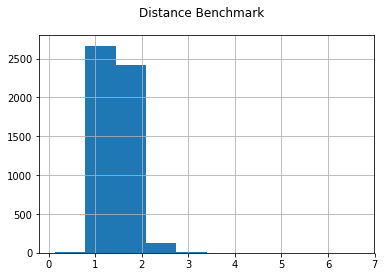

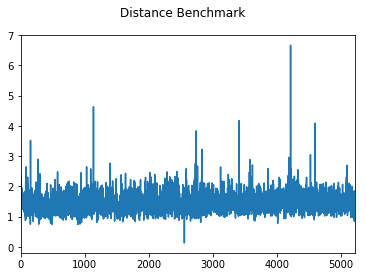

same
False    1.479674
True     1.440751
Name: distance, dtype: float64
same
False    0.290205
True     0.308694
Name: distance, dtype: float64


C:\Users\212778050\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


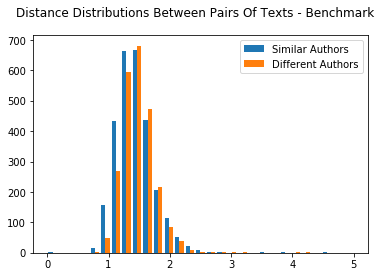

In [27]:
import numpy as np
# pairs = pd.read_csv('pairs_distances.csv')
pairs['distance'].hist()
plt.suptitle('Distance Benchmark')
plt.show()
pairs['distance'].describe()
plt.suptitle('Distance Benchmark')

pairs['distance'].plot()
plt.show()



# see difference between distances of texts that are similar and not
print(pairs.groupby('same').mean()['distance'])
print(pairs.groupby('same').std()['distance'])


group1 = pairs[pairs['same']==True]['distance']
# group1.hist()
# plt.show()
group2 = pairs[pairs['same']==False]['distance']
# group2.hist()
# plt.show()
bins = np.linspace(0, 5, 30)
plt.hist([group1, group2], bins, label=['Similar Authors', 'Different Authors'])
plt.legend(loc='upper right')
plt.suptitle('Distance Distributions Between Pairs Of Texts - Benchmark')
plt.show()

In [28]:
pairs
df.head()

,element,frequency_in_category,category
0,noth,29,0_1
1,hool,27,0_1
2,owl,27,0_1
3,eye,23,0_1
4,tree,22,0_1


In [45]:
sigs = lpa.create_signatures(df_single_pair)
sigs
# dis_mtx = lpa.sockpuppet_distance(signatures1=sigs, signatures2=sigs)
# dis_mtx

C:\Users\212778050\PycharmProjects\LPA\LPA.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ].transform("sum")
C:\Users\212778050\PycharmProjects\LPA\LPA.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  vec["local_weight"] = vec["local_weight"] * pd.Series(betas)


,category,element,KL
0,0_1,able,0.000031
1,0_1,accept,0.000166
2,0_1,aches,0.002279
3,0_1,acknowledged,0.000615
4,0_1,across,0.000392
5,0_1,act,0.000038
6,0_1,actor,0.000856
7,0_1,adds,0.000593
8,0_1,adoring,0.001072
9,0_1,adrenline,0.002262


#### Creating Signatures
Another prominent use of LPA is creating a signature for every category, which is made up of the most meaningful terms for every category, whether in their prominence or absence. Usually, one won't need the full signature, but rather signatures of a certain length, as shown in the paper. Thus, the function `create_and_cut()` creates signatures and keeps the most prominent elements according to `sig_length`, which defaults to 500. 

In [21]:
sigs = lpa.create_and_cut(df, sig_length=1000)
sigs

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

To get a feel for the dataset as a whole, you can check the distance of each document from the domain by computing the summed distance of the signature from the `dvr`.

In [17]:
lpa.distance_summary(df).head()

,KL
category,
1,1.053738
2,1.009002
3,0.979499
4,0.747520
5,0.723911


#### Distances between pairs of categories (Sockpuppet Distance)
Finally, one can use the signatures created to calculate the L1 distance between every pair of categories. 
`sockpuppet_distance` accepts two DataFrames of $n$ and $m$ signatures respectively and compares them, returning a matrix sized $n \times m$. Different signature lengths and epsilons can have dramatic effects on the results.

In [18]:
lpa.sockpuppet_distance(signatures1=sigs.iloc[:5000], signatures2=sigs.iloc[:5000])

NameError: name 'sigs' is not defined

### Further analysis
Once we have calculated the distances between every category, we can perform further analysis on the results, for instance by clustering the sockpuppet distances and finding similar categories. 

## Good Luck!

### References
Miani, A., Hills, T. & Bangerter, A. LOCO: The 88-million-word language of conspiracy corpus. Behav Res (2021). https://doi.org/10.3758/s13428-021-01698-z

Mokryn, O., Ben-Shoshan, H. Domain-based Latent Personal Analysis and its use for impersonation detection in social media. User Model User-Adap Inter 31, 785–828 (2021). https://doi.org/10.1007/s11257-021-09295-7